Author: Gianmarco Alessio

Department of Mathematics and Geosciences, University of Trieste, Italy

Course: Advanced Topics in Machine Learning, Fall 2023

Teacher: Prof. Fabio Anselmi

# Symmetry Regularization on MNIST dataset under rotation trasformation 

This is the first attempt to implement a Fully Connected 1 layer neural network (`number of neurons = 728`) multiclass classification problem that is invariant to the rotation of the MNIST dataset over a certain angle (in my analysis I selected an angle of 3 degree) and to compare the results with the same network but with different regularization terms, in particular:

- the *FCNN* with only the cross entropy loss. (**The CE LOSS**)
- the *FCNN* with the cross entropy loss and the regularization term for the challenge (**The Challenge LOSS**)
- the *FCNN* with the cross entropy loss and the Symmetry-Adapted Regularization terms (**The Symmetry LOSS**)


#### *Challenge 2*: *Discovering **Symmetries** in Data*

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Generate a dataset composed by rotations of 2-dimensional vectors *w.r.t.* a finite subgroup of the rotation group (*e.g.* every 3-4 degrees). Shuffle the dataset.  
Generate the labels according to the orbits.  

Implement a *NN* with one *FC* layer and `ReLU` to classify the orbits elements according to the label.  

Write a Loss that contains 3 terms:

- The regularization term as explained in class using [*soft-sort*](https://github.com/google-research/fast-soft-sort) on rows and columns of the Gramian of the first layer weights; (risp: `use_reg_sort` )
- The cross entropy entropy with orbit labels; (risp: `self.cross_entropy = nn.CrossEntropyLoss()`)
- The norm of the commutator between the covariance matrix of the data and that of the weights, as explained in class.  (risp: `use_reg_commutator`)

We are encouraged to come up with other constraints instead of *1* and especially *3*.  
(risp: instead of *1*  come up with `symmetry_reg_loss = symm_loss(atoms, cardinality, sigma_squared=0.001)` and instead of *2* I come up with `symmetry_comm_loss = comm_loss_function(atoms,train_images)` where i found them in the paper linked below )

In seeking alternatives to constraints *1* and especially *3*, I propose adopting two novel constraints derived from the research findings detailed in the referenced paper. For constraint *1*, I introduce a symmetry regularization loss, denoted as `symmetry_reg_loss`. This loss function is defined by `symm_loss(atoms, cardinality, sigma_squared=0.001)`, where it leverages the concept of symmetry in the representation space to enforce structural coherence. For the alternative to constraint *3*, I suggest the implementation of a symmetry commutator loss, `symmetry_comm_loss`. This is articulated through `comm_loss_function(atoms, train_images)`. 
The proposed constraints, inspired by methodologies detailed in the referenced paper, are designed to enhance the learning process through a focus on symmetry and communication within the model's structure. This approach, referred to as "Symmetry-Adapted Regularization," aims to incorporate symmetry principles directly into the regularization process

Test the invariance of the representation and plot the Gramian of the learned weights. 
We se matrix that manifest symmetries property in particular rotation invariance.



In [39]:
import torch
from torchvision import datasets, transforms
from torchvision import utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch import nn
from fast_soft_sort.pytorch_ops import soft_rank
from fast_soft_sort.pytorch_ops import soft_sort
import torch.nn.functional as F
import random
import numpy as np
# donwload the .py file
import functions
from functions import *

In [40]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=6000, shuffle=False)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


for data, target in train_loader:
    train_images = data
    train_target = target
for data, target in test_loader:
    test_images = data
    test_target = target

rotated_train_images, rotated_train_labels = rotate_images(train_images, train_target,angle=3)
rotated_test_images, rotated_test_labels = rotate_images(test_images, test_target,angle=3)

In [41]:
rotated_train_dataset = torch.utils.data.TensorDataset(rotated_train_images, rotated_train_labels)
rotated_train_loader = DataLoader(rotated_train_dataset, batch_size=6000,shuffle=True) 
rotated_test_dataset = torch.utils.data.TensorDataset(rotated_test_images, rotated_test_labels)
rotated_test_loader = DataLoader(rotated_test_dataset, batch_size=1000,shuffle=True) 
for data, target in rotated_train_loader:
    train_images = data
    train_labels = target
for data, target in rotated_test_loader:
    test_images = data
    test_labels = target

In [42]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        # Layer di input che collega l'input size all'hidden size
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Hidden layer che collega l'hidden size all'output size
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Passaggio attraverso il primo layer lineare e applicazione di ReLU
        x = F.relu(self.fc1(x))
        # Passaggio attraverso il layer di output
        x = self.fc2(x)
        return x

In [43]:
class loss_function(nn.Module):
    def __init__(self, lambda_reg=0.01, lambda_symm=0.01,lambda_comm=0.01,lambda_symm_comm=0.01):
        super(loss_function, self).__init__()
        self.lambda_sort = lambda_reg
        self.lambda_symm = lambda_symm
        self.lambda_comm = lambda_comm
        self.lambda_symm_comm = lambda_symm_comm
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, prediction, labels, weights,train_images, use_reg_sort=False, use_symm_loss=False, use_symm_comm=False):

        reg_loss = 0 
        symmetry_reg_loss = 0 
        ce_loss = self.cross_entropy(prediction, labels)

        total_loss = ce_loss

        if use_reg_sort:
            reg_loss = reg_loss_function(weights)
            total_loss += self.lambda_sort * reg_loss

        if use_symm_loss:
            symmetry_reg_loss = symm_loss(weights, 120, sigma_squared=0.001)
            total_loss += self.lambda_symm * symmetry_reg_loss

        if use_symm_comm:
            symmetry_comm_loss = comm_loss_function(weights,train_images)
            total_loss += self.lambda_symm_comm * symmetry_comm_loss
        

        return total_loss

In [58]:
net = Net(784, 120, 10)

loss_value = loss_function()
optimizer = torch.optim.Adam([
    {'params': net.parameters()},
], lr=0.001)

num_epochs = 500

for epoch in range(num_epochs):

    train_images = train_images.view(train_images.shape[0], -1)
    optimizer.zero_grad()
    prediction = net(train_images)
    weights = net.fc1.weight  

    loss = loss_value(prediction, train_labels, weights, train_images, use_reg_sort=True, use_symm_loss=True, use_symm_comm=False)

    # Backward pass e ottimizzazione
    loss.backward()
    optimizer.step()

    # Stampa la perdita per ogni epoca
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/500], Loss: 2.9295437335968018
Epoch [2/500], Loss: 2.8071603775024414
Epoch [3/500], Loss: 2.7217066287994385
Epoch [4/500], Loss: 2.6277377605438232
Epoch [5/500], Loss: 2.5756468772888184
Epoch [6/500], Loss: 2.4862375259399414
Epoch [7/500], Loss: 2.4354088306427
Epoch [8/500], Loss: 2.3869566917419434
Epoch [9/500], Loss: 2.3245041370391846
Epoch [10/500], Loss: 2.285942792892456
Epoch [11/500], Loss: 2.2378573417663574
Epoch [12/500], Loss: 2.195115089416504
Epoch [13/500], Loss: 2.161280393600464
Epoch [14/500], Loss: 2.1396827697753906
Epoch [15/500], Loss: 2.1000828742980957
Epoch [16/500], Loss: 2.070018768310547
Epoch [17/500], Loss: 2.0556907653808594
Epoch [18/500], Loss: 2.0221354961395264
Epoch [19/500], Loss: 1.9991346597671509
Epoch [20/500], Loss: 1.974671483039856
Epoch [21/500], Loss: 1.9566041231155396
Epoch [22/500], Loss: 1.9260770082473755
Epoch [23/500], Loss: 1.9223569631576538
Epoch [24/500], Loss: 1.8965294361114502
Epoch [25/500], Loss: 1.877724766

KeyboardInterrupt: 

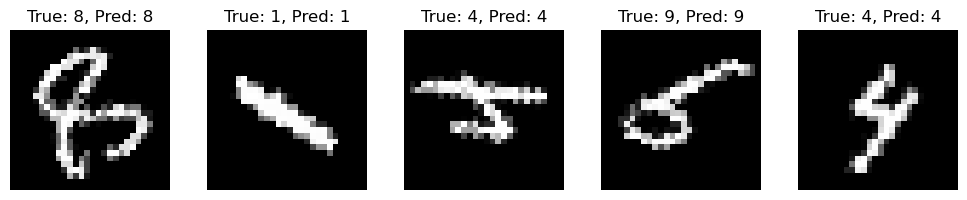

Train Accuracy: 100.0%


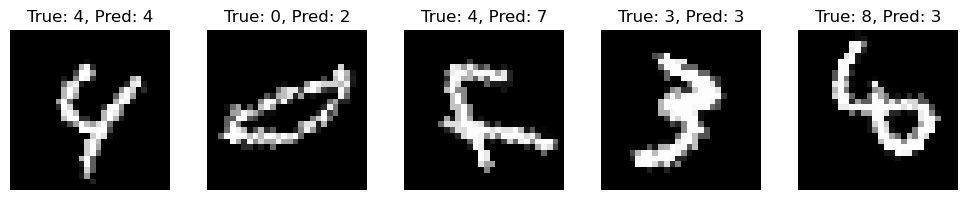

Test Accuracy: 67.5%


In [78]:
# Inizializza il modello
net = Net(784, 125,10)
best_model_params = torch.load('./best_model_weights/125.pth')
net.load_state_dict(best_model_params)

train_accuracy = calculate_accuracy(net, rotated_train_loader)
print(f'Train Accuracy: {train_accuracy * 100}%')
test_accuracy = calculate_accuracy(net, rotated_test_loader)
print(f'Test Accuracy: {test_accuracy * 100}%')

In [71]:
differences = []
differences_control = []

control_img = None

for i, (images, label) in enumerate(test_loader):
    # The order is the same due to the fact that both dataloaders are not shuffled!
    (images_rot, label_rot) = rotated_test_loader.__iter__().__next__()

    if i == 0:
        control_img = torch.randn_like(images)

    # Example of flattening the input
    images = images.view(images.size(0), -1) # Flatten the images
    images_rot = images_rot.view(images_rot.size(0), -1) # Flatten the images
    control_img = control_img.view(control_img.size(0), -1) # Flatten the images

    act = get_activations(images, net, "fc1")
    act_rot = get_activations(images_rot, net, "fc1")
    act_control = get_activations(control_img, net, "fc1")

    # When the non-augmented dataset is over, the rest of the batch is eventually filled with augmentations
    # This check (and fix) avoids dimension mismatches
    if act.shape[0] != act_rot.shape[0]:
        act_rot = act_rot[: act.shape[0]]
        act_control = act_control[: act.shape[0]]

    differences.append(act - act_rot)
    differences_control.append(act - act_control)

    control_img = images_rot
 
avg_norm = torch.linalg.norm(torch.cat(differences, dim=0), dim=1).mean()
avg_norm_control = torch.linalg.norm(torch.cat(differences_control, dim=0), dim=1).mean()

print(f"Average Euclidean norm of the difference: {avg_norm.item()}")
print(f"Average Euclidean norm of the difference, control: {avg_norm_control.item()}")

Average Euclidean norm of the difference: 46.147727966308594
Average Euclidean norm of the difference, control: 48.12147903442383


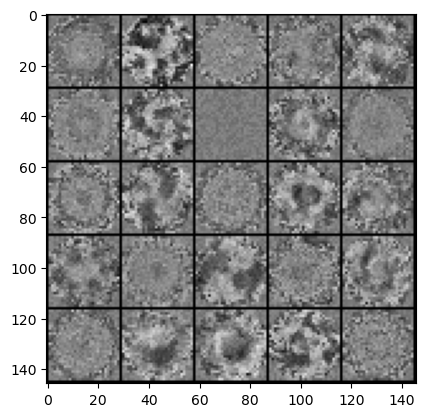

torch.Size([784, 784])
tensor([[-0.0143,  0.0297,  0.0138,  ..., -0.0165,  0.0271,  0.0335],
        [ 0.0238,  0.0091,  0.0071,  ..., -0.0167, -0.0094,  0.0101],
        [-0.0009,  0.0176,  0.0101,  ...,  0.0146, -0.0245,  0.0145],
        ...,
        [-0.0005, -0.0227, -0.0085,  ...,  0.0022, -0.0149,  0.0099],
        [ 0.0212, -0.0342, -0.0064,  ..., -0.0046, -0.0022,  0.0249],
        [-0.0275, -0.0190,  0.0310,  ..., -0.0235,  0.0098,  0.0268]])


In [72]:
# Extracting weights
weights = net.fc1.weight.detach().cpu()

# Normalization
w_min, w_max = weights.min(), weights.max()
plt_weights = (weights - w_min) / (w_max - w_min)


# Reshape weights for a 5x5 grid, assuming each weight vector is of size 28*28
# You need to ensure that there are at least 25 weight vectors
plt_weights = plt_weights[:25].reshape(-1, 1, 28, 28)  # Taking first 25 weight vectors

# Create a 5x5 grid
grid = utils.make_grid(plt_weights, nrow=5, normalize=True, padding=1)
plt.imshow(grid.permute(1, 2, 0))  # Permute the axes to display the image correctly
plt.show()

# Print weight information
print(weights.shape)
print(weights)


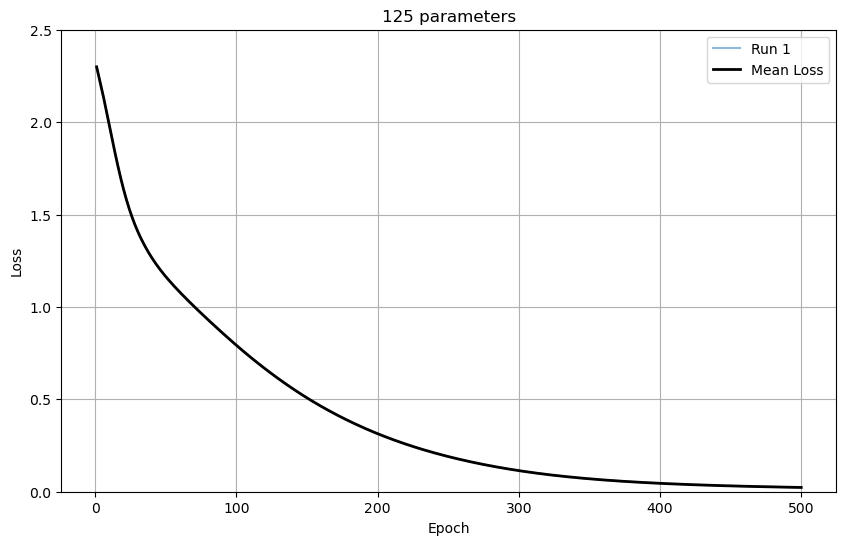

In [76]:
# PER Il PLOT

best_loss = float('inf')
best_params = None
all_losses = []  # Per memorizzare tutte le curve di perdita
num_epochs = 500
num_runs = 1

for run in range(num_runs):
    net = Net(784, 125, 10)
    loss_value = loss_function()
    optimizer = torch.optim.Adam([
        {'params': net.parameters()},
    ], lr=0.001)

    loss_history = []  # To store loss values

    for epoch in range(num_epochs):
        train_images = train_images.view(train_images.shape[0], -1)
        optimizer.zero_grad()

        prediction = net(train_images)
        weights = net.fc1.weight
        loss = loss_value(prediction, train_labels, weights, train_images,
                          use_reg_sort=False,
                          use_symm_loss=False, use_symm_comm=False)

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    all_losses.append(loss_history)  # Aggiungi la storia di perdita di questa esecuzione alla lista generale

    # Verifica se questa esecuzione ha la migliore perdita media
    avg_loss = np.mean(loss_history)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = net.state_dict()  # Salva i parametri della rete

# Calcolare la media delle perdite per ogni epoca
mean_losses = np.mean(all_losses, axis=0)

# Plotting tutte le curve di perdita e la media
plt.figure(figsize=(10, 6))
for i, loss_history in enumerate(all_losses):
    plt.plot(range(1, num_epochs + 1), loss_history, label=f'Run {i+1}', alpha=0.5)
plt.plot(range(1, num_epochs + 1), mean_losses, color='black', label='Mean Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('125 parameters')
plt.legend()
plt.grid(True)
plt.ylim([0, 2.5])
plt.show()

# Salvare i migliori parametri della rete
torch.save(best_params, '125.pth')
